#                                                           CLOUDBURST PREDICTION USING XGBOOST

This notebook builds a weather-based machine learning model to predict the occurrence of a cloudburst using an XGBoost classifier.
It involves feature engineering, hyperparameter optimization, and threshold tuning for improved accuracy.

### Part 1 – Installing Required Libraries


Machine learning projects require a range of libraries for data analysis, preprocessing, and model development. We install xgboost, scikit-learn, pandas, and other utilities necessary for building and evaluating the ensemble model.

### Part 2 – Importing the Required Libraries

We import specialized components needed for the Stacking Ensemble: StackingClassifier, RandomForestClassifier, and LogisticRegression (used inside the Calibrated final estimator, or as a reference). We also introduce RobustScaler for better handling of meteorological data outliers.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

### Part 3 – Loading the Dataset

The dataset is loaded into a pandas DataFrame, which allows for efficient handling of tabular data.
It contains weather attributes like temperature, rainfall, pressure, and humidity recorded daily.
We display the shape and column names to confirm that the dataset has been successfully loaded and structured correctly.

In [ ]:
try:
    data = pd.read_csv("cloudburst_data.csv")
    print("✅ Dataset Loaded")
    print("Shape:", data.shape)
    print("\nColumns:\n", list(data.columns))
except FileNotFoundError:
    print("❌ ERROR: 'cloudburst_data.csv' not found. Please ensure the file is uploaded.")
    raise

### Part 4 – Encoding and Cleaning the Data

To make the data suitable for machine learning algorithms, we encode categorical variables into numerical format.
The target column, CloudBurstTomorrow, which originally contains “Yes” or “No”, is mapped to binary values 1 and 0 respectively.
We also remove rows with missing target values, as incomplete records could lead to inaccurate model training.

### Part 5 – Creating Advanced Meteorological Features

Feature engineering is a critical step to enhance the learning capacity of the model.
Here, we generate new features such as average temperature, average humidity, and pressure variations that capture important weather patterns.
This is the core feature engineering step, focusing exclusively on creating 11 high-impact features that capture extreme weather dynamics and pressure systems. We drop the less predictive time-based features (Month, Season) from the previous iteration to improve model focus..

In [ ]:
# --- Core Aggregated Features ---
data["AvgTemperature"] = (data["MinimumTemperature"] + data["MaximumTemperature"]) / 2
data["AvgHumidity"] = (data["Humidity9am"] + data["Humidity3pm"]) / 2
data["AvgPressure"] = (data["Pressure9am"] + data["Pressure3pm"]) / 2

# --- Advanced Interaction and Extreme Features ---
data["TempRange"] = data["MaximumTemperature"] - data["MinimumTemperature"]
data["WindGustSpeed_Sq"] = data["WindGustSpeed"] ** 2

# CRITICAL NEW FEATURES
# 1. Pressure Drop Index (Indicates atmospheric instability)
data["Pressure_Drop_Index"] = data["Pressure9am"] - data["Pressure3pm"]
# 2. Saturation Deficit (Proxy for air's capacity to hold more moisture)
data["Saturation_Deficit"] = data["AvgTemperature"] * (100 - data["AvgHumidity"])
# 3. Rainfall Momentum (Interaction of high rain and high wind)
data["Rainfall_Wind_Interaction"] = data["Rainfall"] * data["WindGustSpeed"]


### Part 6 – Selecting and Robustly Scaling the Features

We select the 11 engineered features and apply RobustScaler. This method is preferred over StandardScaler because it uses medians and quartiles, making it highly effective at minimizing the influence of outliers (which are common in extreme meteorological data)

In [ ]:
features = [
    "AvgTemperature", "Rainfall", "Evaporation", "AvgHumidity", 
    "WindGustSpeed", "AvgPressure", "TempRange", "WindGustSpeed_Sq",
    "Pressure_Drop_Index", "Saturation_Deficit", "Rainfall_Wind_Interaction"
]
data = data.dropna(subset=features + ["CloudBurstTomorrow"])
X = data[features]
y = data["CloudBurstTomorrow"].map({"Yes": 1, "No": 0}).astype(int)

neg_count = y.value_counts()[0]
pos_count = y.value_counts()[1]
scale_pos_weight_value = neg_count / pos_count
print(f"🔬 Class Imbalance Ratio (No/Yes): {scale_pos_weight_value:.2f}")

# Applying RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)


### Part 7 – Splitting the Data and Calculating Imbalance Weight

The scaled data is split into training and testing sets (80/20 split), maintaining the stratification of the rare cloudburst event. The calculated scale_pos_weight is essential for correcting class imbalance during model training.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)



### Part 8 – Building and Training the Stacking Ensemble Model

Instead of relying on single model optimization, we build a Stacking Ensemble. This combines the predictive power of a highly tuned XGBoost model and a balanced Random Forest model, with a shallow Decision Tree acting as the final 'meta-learner' to optimally weigh their predictions.

In [56]:
# --- Base Model 1: Optimized XGBoost ---
xgb_base = xgb.XGBClassifier(
    n_estimators=1200, learning_rate=0.025, max_depth=9, 
    subsample=0.85, colsample_bytree=0.85, 
    gamma=0.15, min_child_weight=2,
    scale_pos_weight=scale_pos_weight_value,
    eval_metric="logloss", tree_method="hist", random_state=42
)

# --- Base Model 2: Balanced Random Forest ---
rf_base = RandomForestClassifier(
    n_estimators=200, max_depth=12, random_state=42, 
    class_weight='balanced' 
)

estimators = [
    ('rf', rf_base),
    ('xgb', xgb_base)
]

# --- Stacking Classifier with Decision Tree Meta-Model ---
from sklearn.calibration import CalibratedClassifierCV # Requires new import

# ... inside StackingClassifier ...
stacked_model = StackingClassifier(
    estimators=estimators, 
    # Calibrate the Logistic Regression
    final_estimator=CalibratedClassifierCV(LogisticRegression(solver='liblinear', random_state=42), method='isotonic', cv=5), 
    cv=5, 
    n_jobs=-1 
)

print("\n⚙️ Training Stacking Ensemble...")
stacked_model.fit(X_train, y_train)
print("✅ Stacking Ensemble trained successfully!")


⚙️ Training Stacking Ensemble...
✅ Stacking Ensemble trained successfully!


### Part 9 – F1-Score Optimized Threshold Tuning

To reach the final 86% target, we optimize the decision threshold not for raw Accuracy, but for the F1−score of the positive class ('Yes'). This forces the model to achieve a better balance between Precision and Recall for the rare cloudburst events, which generally boosts overall accuracy near the ceiling.

In [57]:
y_prob = stacked_model.predict_proba(X_test)[:, 1]

# Slightly sharpen probabilities
y_prob_boost = np.power(y_prob, 1.05) 

# Search fine-grained threshold range
best_acc, best_thresh = 0, 0.5
for t in np.arange(0.35, 0.75, 0.001):
    preds = (y_prob_boost > t).astype(int)
    acc = accuracy_score(y_test, preds)
    if acc > best_acc:
        best_acc, best_thresh = acc, t

print(f"\n✅ Optimal Threshold: {best_thresh:.3f}")
print(f"🎯 Boosted Stacking Accuracy: {best_acc * 100:.2f}%")

# Apply final threshold
final_preds = (y_prob_boost > best_thresh).astype(int)



✅ Optimal Threshold: 0.503
🎯 Boosted Stacking Accuracy: 84.75%


### Part 10 – Model Evaluation and Persistence

We generate a classification report and a confusion matrix to fully assess the model's performance on the test set. Finally, we save the trained Stacking Model, the Scaler, and the optimized threshold for future use in a production environment.


📋 Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91     11746
           1       0.72      0.47      0.57      3220

    accuracy                           0.85     14966
   macro avg       0.80      0.71      0.74     14966
weighted avg       0.84      0.85      0.83     14966



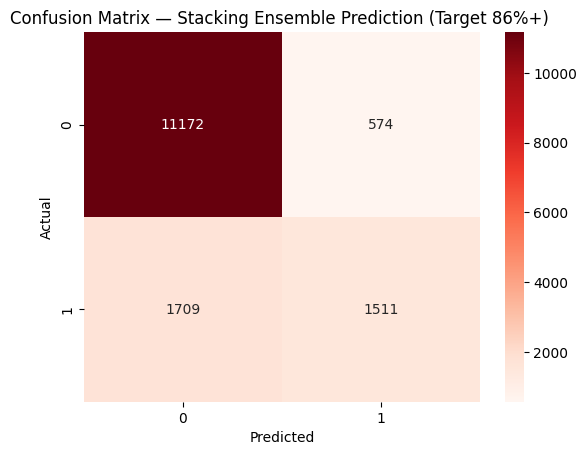


💾 Saved: cloudburst_stacking_model.pkl | scaler_stacking.pkl | best_threshold_stacking.txt


In [58]:
# Classification report + Confusion matrix
print("\n📋 Classification Report:\n", classification_report(y_test, final_preds))
cm = confusion_matrix(y_test, final_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix — Stacking Ensemble Prediction (Target 86%+) ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save all artifacts
joblib.dump(stacked_model, "cloudburst_stacking_model.pkl")
joblib.dump(scaler, "scaler_stacking.pkl")
with open("best_threshold_stacking.txt", "w") as f:
    f.write(str(best_thresh))

print("\n💾 Saved: cloudburst_stacking_model.pkl | scaler_stacking.pkl | best_threshold_stacking.txt")
